本案例仅仅用于演示和测试`alphalens`包，策略本身并没有实际意义

In [1]:
%load_ext zipline

### 运行策略

In [2]:
%%zipline --start 2017-1-1 --end 2018-5-2 -o result.pkl

import talib
import numpy as np
import math
import logbook

from zipline.api import *
from zipline.pipeline.fundamentals import Fundamentals
from zipline.pipeline import Pipeline
from zipline.pipeline.builtin import TopAverageAmount
from zipline.pipeline.factors import RSI

from zipline.finance import commission, slippage

log = logbook.Logger('RSI')


def make_pipeline():

    return Pipeline(
        columns={
            'rsi': RSI(window_length=15),
            'sector': Fundamentals.info.sector_code.latest,
        },
        # 只选择成交额前500位的股票
        screen=TopAverageAmount(50))


# Setup our variables
def initialize(context):
    # 设置手续费及滑点
    set_commission(commission.PerShare(cost=0))
    set_slippage(slippage.FixedSlippage(spread=0))
    
    context.max_notional = 100000
    context.intc = sid(333)  #symbols(['000333','000002','300017'])
    context.LOW_RSI = 30
    context.HIGH_RSI = 70
    attach_pipeline(make_pipeline(), 'rsi_pipeline')
    schedule_function(rebalance, date_rules.every_day(),
                      time_rules.market_open())


def before_trading_start(context, data):
    #context.output = pipeline_output('rsi_pipeline')
    #print(context.output.head())
    pass

def rebalance(context, data):
    # 接收pipeline输出结果
    output = pipeline_output('rsi_pipeline')

    # Get our current positions
    positions = context.portfolio.positions
    
    # 信号触发可卖出和可买入的股票
    signal_sell = output[output['rsi'] > context.HIGH_RSI].index
    signal_buy = output[output['rsi'] < context.LOW_RSI].index
    
    for s in signal_sell:
        # 存在于持有的头寸中
        if s in positions:
            # 清空头寸
            order_target(s, 0)
            # amount代表持仓数量，而非金额
            current_intel_shares = positions[s].amount
            log.info('RSI is at ' + str(s) + ', 卖出 ' +
                     str(current_intel_shares) + ' shares')
            
    for s in signal_buy:
        # 对于信号提示可买入，但尚未买入的股票，买入固定金额
        if s not in positions:
            o = order_target_value(s, context.max_notional)
            log.info('RSI is at ' + str(s) + ', 买入 ' +
                     str(get_order(o).amount) + ' shares')

    # record the current RSI value and the current price of INTC.
    # record(intcRSI=intc_rsi, intcPRICE=data.current(context.intc, 'close'))

[2018-05-14 12:00:25.605366] INFO: RSI: RSI is at 万 科Ａ(000002), 买入 4823 shares
[2018-05-14 12:00:25.608954] INFO: RSI: RSI is at 步 步 高(002251), 买入 6042 shares
[2018-05-14 12:00:25.611547] INFO: RSI: RSI is at 东方财富(300059), 买入 5854 shares
[2018-05-14 12:00:25.613596] INFO: RSI: RSI is at 掌趣科技(300315), 买入 10752 shares
[2018-05-14 12:00:25.615444] INFO: RSI: RSI is at 民生银行(600016), 买入 10976 shares
[2018-05-14 12:00:25.617580] INFO: RSI: RSI is at 驰宏锌锗(600497), 买入 13812 shares
[2018-05-14 12:00:25.619399] INFO: RSI: RSI is at 兴业银行(601166), 买入 6158 shares
[2018-05-14 12:00:25.637067] INFO: RSI: RSI is at 南洋科技(002389), 买入 4118 shares
[2018-05-14 12:00:25.641997] INFO: RSI: RSI is at 华安证券(600909), 买入 7987 shares
[2018-05-14 12:00:25.645023] INFO: RSI: RSI is at 国泰君安(601211), 买入 5321 shares
[2018-05-14 12:00:25.671854] INFO: RSI: RSI is at 三江购物(601116), 买入 2617 shares
[2018-05-14 12:00:25.687861] INFO: RSI: RSI is at 四川双马(000935), 买入 3819 shares
[2018-05-14 12:00:25.690535] INFO: RSI: RSI is a

/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/empyrical-0.4.2-py3.6.egg/empyrical/stats.py:676: RuntimeWarning: invalid value encountered in true_divide
/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/empyrical-0.4.2-py3.6.egg/empyrical/stats.py:762: RuntimeWarning: invalid value encountered in true_divide
/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/empyrical-0.4.2-py3.6.egg/empyrical/stats.py:762: RuntimeWarning: divide by zero encountered in true_divide


[2018-05-14 12:00:26.340194] INFO: RSI: RSI is at 佳沃股份(300268), 买入 3125 shares
[2018-05-14 12:00:26.381537] INFO: RSI: RSI is at 东旭光电(000413), 买入 10050 shares
[2018-05-14 12:00:26.383189] INFO: RSI: RSI is at 中国联通(600050), 买入 15174 shares
[2018-05-14 12:00:26.385582] INFO: RSI: RSI is at 中体产业(600158), 买入 4189 shares
[2018-05-14 12:00:26.409328] INFO: RSI: RSI is at 中粮生化(000930), 买入 7552 shares
[2018-05-14 12:00:26.411997] INFO: RSI: RSI is at 中体产业(600158), 买入 4189 shares
[2018-05-14 12:00:26.415946] INFO: RSI: RSI is at 际华集团(601718), 买入 11428 shares
[2018-05-14 12:00:26.444577] INFO: RSI: RSI is at 泰尔股份(002347), 买入 9569 shares
[2018-05-14 12:00:26.446536] INFO: RSI: RSI is at 中体产业(600158), 买入 4189 shares
[2018-05-14 12:00:26.473875] INFO: RSI: RSI is at 兴业银行(601166), 卖出 6158 shares
[2018-05-14 12:00:26.476356] INFO: RSI: RSI is at 上峰水泥(000672), 买入 9132 shares
[2018-05-14 12:00:26.482437] INFO: RSI: RSI is at 中体产业(600158), 买入 4189 shares
[2018-05-14 12:00:26.515838] INFO: RSI: RSI is at

[2018-05-14 12:00:28.858217] INFO: RSI: RSI is at 河钢股份(000709), 买入 20876 shares
[2018-05-14 12:00:28.860179] INFO: RSI: RSI is at 招商蛇口(001979), 买入 5319 shares
[2018-05-14 12:00:28.861913] INFO: RSI: RSI is at 荣盛发展(002146), 买入 8802 shares
[2018-05-14 12:00:28.863519] INFO: RSI: RSI is at 唐山港(601000), 买入 15527 shares
[2018-05-14 12:00:28.912989] INFO: RSI: RSI is at 雏鹰农牧(002477), 买入 19193 shares
[2018-05-14 12:00:28.915371] INFO: RSI: RSI is at 庞大集团(601258), 买入 32467 shares
[2018-05-14 12:00:29.004601] INFO: RSI: RSI is at 京汉股份(000615), 买入 5640 shares
[2018-05-14 12:00:29.048886] INFO: RSI: RSI is at 葛洲坝(600068), 买入 9505 shares
[2018-05-14 12:00:29.094642] INFO: RSI: RSI is at 北新建材(000786), 买入 7299 shares
[2018-05-14 12:00:29.096631] INFO: RSI: RSI is at 棕榈股份(002431), 买入 9541 shares
[2018-05-14 12:00:29.099053] INFO: RSI: RSI is at 清新环境(002573), 买入 5133 shares
[2018-05-14 12:00:29.100866] INFO: RSI: RSI is at 万华化学(600309), 买入 3735 shares
[2018-05-14 12:00:29.286093] INFO: RSI: RSI is at 

[2018-05-14 12:00:33.689459] INFO: Performance: returning cash: 0.0
[2018-05-14 12:00:33.725684] INFO: RSI: RSI is at 中泰化学(002092), 买入 6451 shares
[2018-05-14 12:00:33.786662] INFO: RSI: RSI is at 中国联通(600050), 卖出 13386 shares
[2018-05-14 12:00:33.897808] INFO: RSI: RSI is at 兴业银行(601166), 卖出 5865 shares
[2018-05-14 12:00:33.898801] INFO: RSI: RSI is at 浙商证券(601878), 卖出 6246 shares
[2018-05-14 12:00:34.011249] INFO: RSI: RSI is at 中泰化学(002092), 卖出 6451 shares
[2018-05-14 12:00:34.012326] INFO: RSI: RSI is at 格林美(002340), 卖出 14471 shares
[2018-05-14 12:00:34.013571] INFO: RSI: RSI is at 江西铜业(600362), 卖出 5443 shares
[2018-05-14 12:00:34.014792] INFO: RSI: RSI is at 恒生电子(600570), 卖出 2580 shares
[2018-05-14 12:00:34.177192] INFO: RSI: RSI is at 中兴通讯(000063), 卖出 4593 shares
[2018-05-14 12:00:34.332378] INFO: RSI: RSI is at 中国银河(601881), 卖出 8223 shares
[2018-05-14 12:00:34.389641] INFO: RSI: RSI is at 中国联通(600050), 买入 13192 shares
[2018-05-14 12:00:34.495125] INFO: RSI: RSI is at 万 科Ａ(000002

[2018-05-14 12:00:39.344784] INFO: RSI: RSI is at 三六零(601360), 买入 1977 shares
[2018-05-14 12:00:39.419395] INFO: RSI: RSI is at 三一重工(600031), 卖出 12165 shares
[2018-05-14 12:00:39.497176] INFO: RSI: RSI is at 农业银行(601288), 卖出 27247 shares
[2018-05-14 12:00:39.571708] INFO: RSI: RSI is at 云铝股份(000807), 卖出 8319 shares
[2018-05-14 12:00:39.572845] INFO: RSI: RSI is at 北方稀土(600111), 卖出 6203 shares
[2018-05-14 12:00:39.573865] INFO: RSI: RSI is at 三六零(601360), 卖出 1977 shares
[2018-05-14 12:00:39.654080] INFO: RSI: RSI is at 万 科Ａ(000002), 卖出 3496 shares
[2018-05-14 12:00:39.655073] INFO: RSI: RSI is at 格力电器(000651), 卖出 2398 shares
[2018-05-14 12:00:39.657530] INFO: RSI: RSI is at 中环股份(002129), 买入 8865 shares
[2018-05-14 12:00:39.733209] INFO: RSI: RSI is at 中信证券(600030), 卖出 5428 shares
[2018-05-14 12:00:39.734277] INFO: RSI: RSI is at 华友钴业(603799), 卖出 1197 shares
[2018-05-14 12:00:39.735195] INFO: RSI: RSI is at 洛阳钼业(603993), 卖出 14836 shares
[2018-05-14 12:00:39.811060] INFO: RSI: RSI is at 上

[2018-05-14 12:00:44.878504] INFO: RSI: RSI is at 乐视网(300104), 买入 22222 shares
[2018-05-14 12:00:44.978854] INFO: RSI: RSI is at 格林美(002340), 买入 14064 shares
[2018-05-14 12:00:44.980043] INFO: RSI: RSI is at 洛阳钼业(603993), 买入 12391 shares
[2018-05-14 12:00:45.263202] INFO: RSI: RSI is at 中国平安(601318), 买入 1498 shares
[2018-05-14 12:00:45.526696] INFO: RSI: RSI is at 中环股份(002129), 卖出 8865 shares
[2018-05-14 12:00:45.633252] INFO: RSI: RSI is at 海康威视(002415), 买入 2630 shares
[2018-05-14 12:00:45.636226] INFO: RSI: RSI is at 复星医药(600196), 买入 2651 shares
[2018-05-14 12:00:45.638684] INFO: RSI: RSI is at 华友钴业(603799), 买入 995 shares
[2018-05-14 12:00:45.752616] INFO: RSI: RSI is at 赣锋锂业(002460), 买入 1561 shares
[2018-05-14 12:00:45.969279] INFO: RSI: RSI is at 分众传媒(002027), 买入 9746 shares
[2018-05-14 12:00:46.074339] INFO: RSI: RSI is at 光环新网(300383), 买入 6570 shares
[2018-05-14 12:00:46.286335] INFO: RSI: RSI is at 航天信息(600271), 买入 4244 shares
[2018-05-14 12:00:46.428748] INFO: Performance: afte

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2017-01-03 07:00:00+00:00,NaN,0.000000,NaN,0.009712,NaN,NaN,0.000,1.000000e+07,0.000000e+00,0.000000e+00,...,0.0,0.0,0,NaN,1.000000e+07,0.000000e+00,0.000000e+00,1,[],0.0
2017-01-04 07:00:00+00:00,0.000000,0.000000,0.000000,0.017593,0.021406,0.000000,-707768.750,9.292231e+06,7.077688e+05,7.077688e+05,...,0.0,0.0,0,NaN,1.000000e+07,0.000000e+00,0.000000e+00,2,"[{'amount': 4823, 'dt': 2017-01-04 07:00:00+00...",0.0
2017-01-05 07:00:00+00:00,0.003458,0.000377,0.091373,0.017435,0.083084,-0.040922,-294032.440,8.998199e+06,1.005574e+06,1.005574e+06,...,0.0,0.0,0,NaN,9.292231e+06,7.077688e+05,7.077688e+05,3,"[{'amount': 4118, 'dt': 2017-01-05 07:00:00+00...",0.0
2017-01-06 07:00:00+00:00,0.018284,-0.001774,-0.192395,0.011356,0.115404,0.112495,0.000,8.998199e+06,9.840639e+05,9.840639e+05,...,0.0,0.0,0,-6.544553,8.998199e+06,1.005574e+06,1.005574e+06,4,[],0.0
2017-01-09 07:00:00+00:00,0.016384,-0.001624,-0.176851,0.016261,0.100950,0.116136,-100545.140,8.897654e+06,1.086103e+06,1.086103e+06,...,0.0,0.0,0,-5.359476,8.998199e+06,9.840639e+05,9.840639e+05,5,"[{'amount': 2617, 'dt': 2017-01-09 07:00:00+00...",0.0
2017-01-10 07:00:00+00:00,0.015936,-0.000984,-0.091083,0.014560,0.095760,0.081481,-501037.690,8.396616e+06,1.593543e+06,1.593543e+06,...,0.0,0.0,0,-2.959838,8.897654e+06,1.086103e+06,1.086103e+06,6,"[{'amount': 3819, 'dt': 2017-01-10 07:00:00+00...",0.0
2017-01-11 07:00:00+00:00,0.017887,-0.002881,-0.133767,0.007377,0.104382,0.111637,-194822.080,8.201794e+06,1.769400e+06,1.769400e+06,...,0.0,0.0,0,-6.025263,8.396616e+06,1.593543e+06,1.593543e+06,7,"[{'amount': 2353, 'dt': 2017-01-11 07:00:00+00...",0.0
2017-01-12 07:00:00+00:00,0.019341,-0.005066,-0.169830,0.002279,0.102578,0.131749,0.000,8.201794e+06,1.747545e+06,1.747545e+06,...,0.0,0.0,0,-7.886048,8.201794e+06,1.769400e+06,1.769400e+06,8,[],0.0
2017-01-13 07:00:00+00:00,0.019309,-0.006965,-0.206816,0.002971,0.095975,0.130189,-96406.250,8.105388e+06,1.824960e+06,1.824960e+06,...,0.0,0.0,0,-9.046223,8.201794e+06,1.747545e+06,1.747545e+06,9,"[{'amount': 3125, 'dt': 2017-01-13 07:00:00+00...",0.0
2017-01-16 07:00:00+00:00,0.035824,-0.013839,-0.360783,0.002830,0.090519,0.139298,0.000,8.105388e+06,1.756224e+06,1.756224e+06,...,0.0,0.0,0,-8.684267,8.105388e+06,1.824960e+06,1.824960e+06,10,[],0.0


### 每年的交易天数

In [3]:
import empyrical as ep

In [4]:
ep.utils.default_returns_func('000300','2016-01-01','2016-12-31').shape

(244,)

In [5]:
ep.utils.default_returns_func('000300','2017-01-01','2017-12-31').shape

(244,)

### 投资组合分析

In [6]:
import pyfolio as pf
import pandas as pd
#import empyrical as ep

#### 提取指标

In [7]:
results = pd.read_pickle('result.pkl')
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

#### 单图例子
绘制排名前5位的回撤周期

/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/numpy-1.14.3-py3.6-linux-x86_64.egg/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Text(0.5,0,'日期')

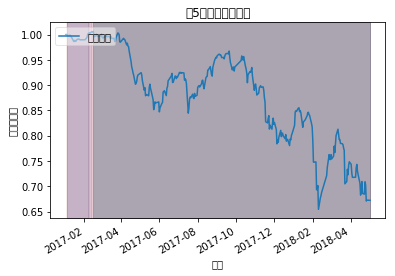

In [8]:
# tearsheet才可以正常显示中文
pf.plot_drawdown_periods(returns, top=5).set_xlabel('日期')

#### 完整`tear sheet`(工作底稿)示例
为算法创建一个完整的工作表。例如，将实时开始日期设置为任意值。

**一般而言，`live_start_date`应设置接近回测结束日期**

In [9]:
live_start_date = returns.index[-20]

/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/numpy-1.14.3-py3.6-linux-x86_64.egg/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


最差回撤,净回撤百分比,波峰日期,波谷日期,回本日期,持续天数
0,34.99,2017-02-16,2018-02-09,NaT,NaN
1,1.42,2017-01-05,2017-01-16,2017-02-08,25
2,0.12,2017-02-09,2017-02-10,2017-02-13,3
3,0.03,2017-02-14,2017-02-15,2017-02-16,3
4,0.00,2017-01-03,2017-01-03,2017-01-03,1


2017-01-03 00:00:00+00:00         NaN
2017-01-04 00:00:00+00:00         NaN
2017-01-05 00:00:00+00:00         NaN
2017-01-06 00:00:00+00:00         NaN
2017-01-09 00:00:00+00:00         NaN
2017-01-10 00:00:00+00:00         NaN
2017-01-11 00:00:00+00:00         NaN
2017-01-12 00:00:00+00:00         NaN
2017-01-13 00:00:00+00:00         NaN
2017-01-16 00:00:00+00:00         NaN
2017-01-17 00:00:00+00:00         NaN
2017-01-18 00:00:00+00:00         NaN
2017-01-19 00:00:00+00:00         NaN
2017-01-20 00:00:00+00:00         NaN
2017-01-23 00:00:00+00:00         NaN
2017-01-24 00:00:00+00:00         NaN
2017-01-25 00:00:00+00:00         NaN
2017-01-26 00:00:00+00:00         NaN
2017-02-03 00:00:00+00:00         NaN
2017-02-06 00:00:00+00:00         NaN
2017-02-07 00:00:00+00:00         NaN
2017-02-08 00:00:00+00:00         NaN
2017-02-09 00:00:00+00:00         NaN
2017-02-10 00:00:00+00:00         NaN
2017-02-13 00:00:00+00:00         NaN
2017-02-14 00:00:00+00:00         NaN
2017-02-15 0

/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/matplotlib/mathtext.py:849: MathTextWarning: Font 'default' does not have a glyph for '\u7cfb' [U+7cfb]
  MathTextWarning)
/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/matplotlib/mathtext.py:850: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)
/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/matplotlib/mathtext.py:849: MathTextWarning: Font 'default' does not have a glyph for '\u6570' [U+6570]
  MathTextWarning)
/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/matplotlib/mathtext.py:849: MathTextWarning: Font 'default' does not have a glyph for '\u76f8' [U+76f8]
  MathTextWarning)
/home/ldf/an

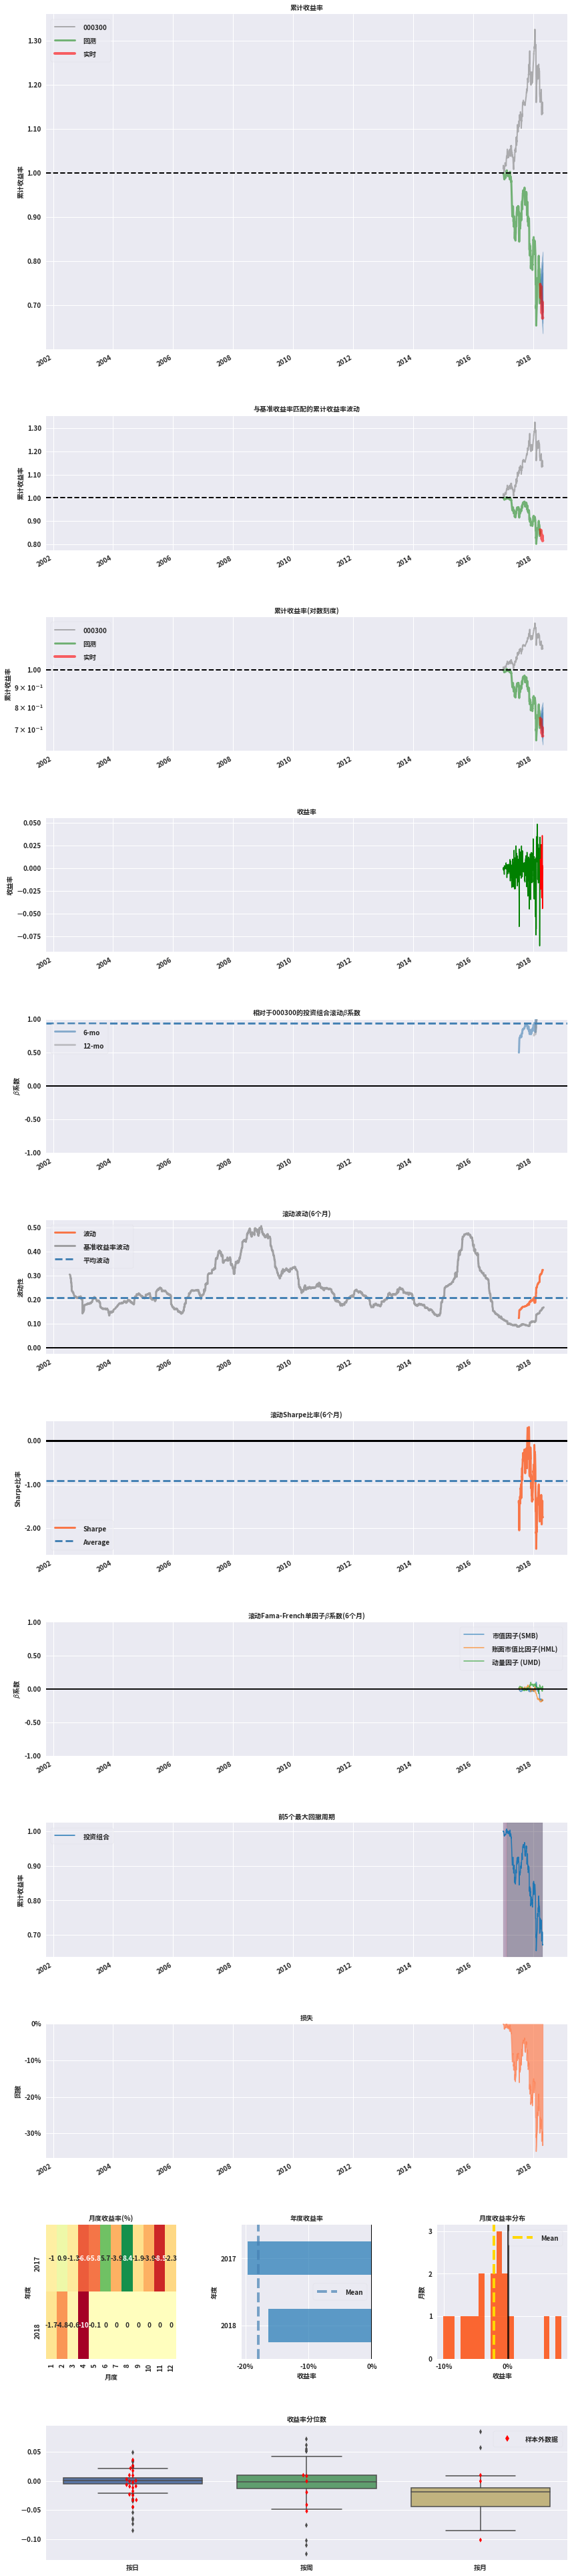

压力事件,mean,min,max
New Normal,-0.11%,-8.57%,4.84%


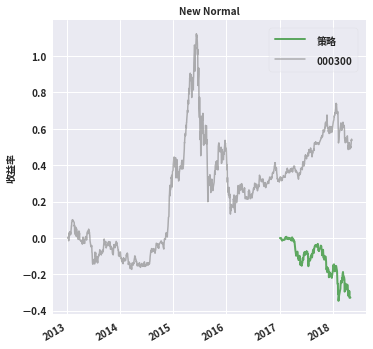

多头头寸(前十位),max
sid,
600158,5.39%
600576,2.73%
300104,2.11%
000786,1.95%
600276,1.94%
603993,1.91%
600970,1.86%
001979,1.84%
601088,1.82%


空头头寸(前十位),max
sid,


头寸绝对值(前十位),max
sid,
600158,5.39%
600576,2.73%
300104,2.11%
000786,1.95%
600276,1.94%
603993,1.91%
600970,1.86%
001979,1.84%
601088,1.82%


头寸绝对值历史清单,max
sid,
600158,5.39%
600576,2.73%
300104,2.11%
000786,1.95%
600276,1.94%
603993,1.91%
600970,1.86%
001979,1.84%
601088,1.82%


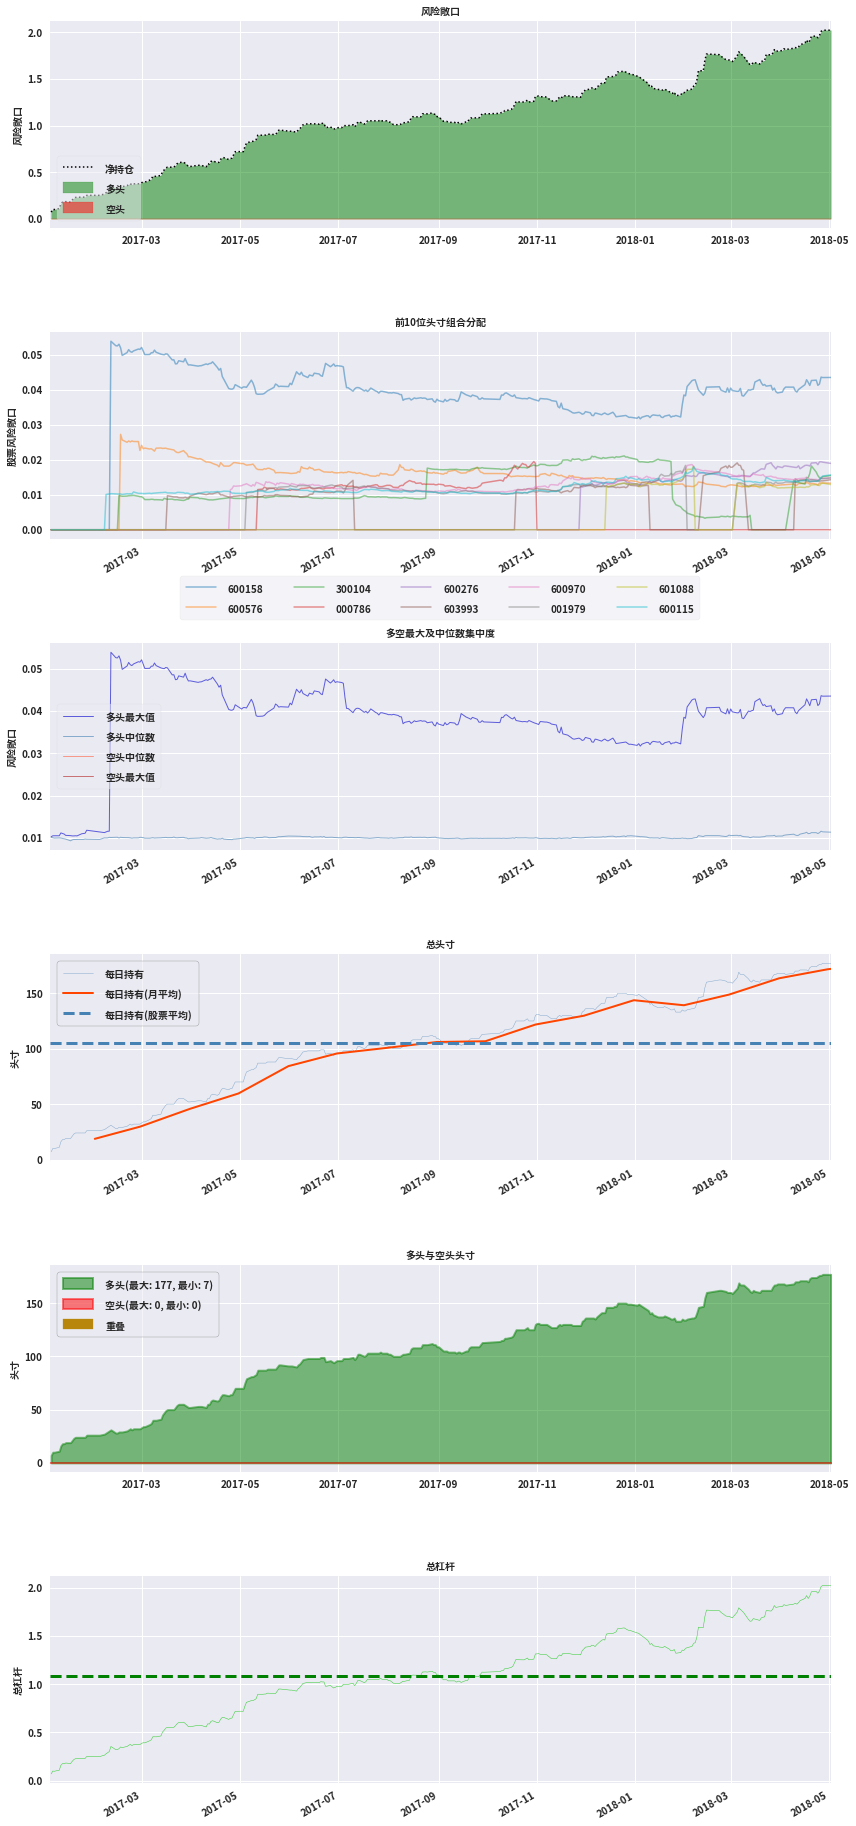

/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


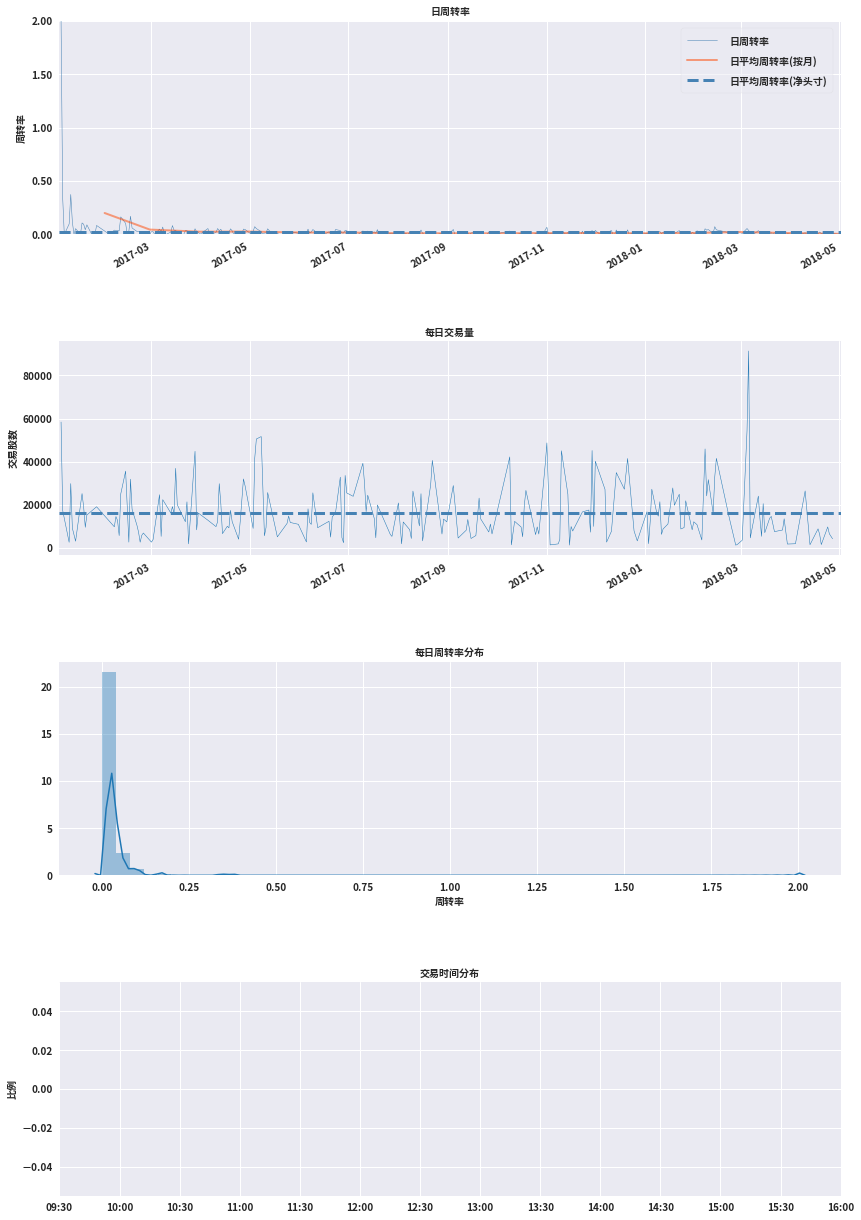

/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/pyfolio-0.8.0-py3.6.egg/pyfolio/round_trips.py:80: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/pyfolio-0.8.0-py3.6.egg/pyfolio/round_trips.py:88: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/pyfolio-0.8.0-py3.6.egg/pyfolio/round_trips.py:382: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  round_trips.groupby('symbol')['returns'].agg(RETURN_STATS).T


概要统计,所有交易,空头交易,多头交易
完成交易总数,302.00,2.00,300.00
盈利比率,0.40,0.50,0.40
盈利次数,121.00,1.00,120.00
亏损次数,181.00,1.00,180.00
持平次数,0.00,0.00,0.00


盈亏统计,所有交易,空头交易,多头交易
总利润,¥-3417443.00,¥-1642.92,¥-3415800.08
毛利润,¥1605315.89,¥5423.70,¥1599892.19
毛亏损,¥-5022758.88,¥-7066.62,¥-5015692.26
盈亏因子,¥0.32,¥0.77,¥0.32
平均交易净利润,¥-11316.04,¥-821.46,¥-11386.00
盈利交易平均值,¥13267.07,¥5423.70,¥13332.43
亏损交易平均值,¥-27750.05,¥-7066.62,¥-27864.96
盈亏均值因子,¥0.48,¥0.77,¥0.48
交易最大盈利,¥65107.08,¥5423.70,¥65107.08
交易最大亏损,¥-247318.56,¥-7066.62,¥-247318.56


周期统计,所有交易,空头交易,多头交易
平均周期,168 days 02:10:32.374172,77 days,168 days 16:45:00.590000
中位数周期,89 days 00:00:00,77 days,89 days 00:00:00
最长周期,482 days 17:00:01,128 days,482 days 17:00:01
最短周期,4 days 17:00:01,26 days,4 days 17:00:01


收益率统计,所有交易,空头交易,多头交易
所有已完成交易平均收益率,-0.18%,-0.00%,-0.18%
盈利交易平均收益率,0.16%,0.08%,0.16%
亏损交易平均收益率,-0.41%,-0.08%,-0.41%
所有已完成交易中位数收益率,-0.09%,-0.00%,-0.09%
盈利交易中位数收益率,0.12%,0.08%,0.12%
亏损交易中位数收益率,-0.36%,-0.08%,-0.36%
最大盈利率,0.72%,0.08%,0.72%
最大亏损率,-3.68%,-0.08%,-3.68%


个股统计,000001,000002,000063,000100,000333,000401,000413,000506,000507,000514,000595,000600,000615,000651,000672,000709,000717,000725,000732,000762,000776,000778,000786,000792,000806,000807,000830,000839,000852,000856,000858,000868,000877,000878,000885,000930,000935,000958,000970,001979,002011,002024,002027,002049,002056,002092,002129,002143,002146,002158,002176,002230,002236,002251,002300,002302,002305,002307,002323,002340,002342,002346,002347,002350,002352,002373,002388,002389,002405,002407,002415,002431,002450,002457,002460,002466,002477,002497,002573,002594,002651,002695,002797,002916,300017,300059,300070,300104,300137,300157,300268,300304,300315,300334,300344,300355,300376,300383,300699,600000,600008,600016,600019,600025,600028,600029,600030,600031,600036,600048,600050,600068,600069,600104,600111,600115,600125,600148,600158,600171,600196,600209,600266,600271,600275,600276,600291,600309,600340,600362,600383,600392,600425,600435,600460,600466,600487,600497,600507,600516,600519,600547,600549,600550,600570,600576,600577,600588,600606,600679,600690,600698,600703,600717,600722,600755,600807,600827,600874,600887,600901,600909,600939,600970,601000,601011,601088,601108,601116,601166,601186,601211,601212,601216,601228,601229,601258,601288,601318,601326,601328,601336,601360,601375,601390,601398,601600,601601,601611,601618,601668,601688,601718,601766,601878,601881,601899,601939,601988,601989,601992,603300,603444,603616,603799,603881,603969,603993
所有已完成交易平均收益率,0.02%,0.13%,0.15%,-0.33%,0.04%,0.09%,-0.04%,-0.76%,-0.28%,-0.54%,-0.70%,-0.69%,-0.70%,0.04%,0.16%,-0.15%,-0.20%,0.07%,0.14%,-0.48%,-0.07%,-0.47%,0.72%,-0.02%,-0.64%,-0.10%,-0.02%,-0.24%,-0.69%,-0.76%,0.07%,-0.56%,0.13%,-0.41%,-0.69%,0.03%,-0.36%,-0.71%,-0.51%,0.30%,-0.69%,0.10%,0.04%,0.28%,-0.26%,0.09%,-0.03%,-0.50%,0.04%,-0.44%,-0.36%,0.19%,-0.22%,-0.19%,-0.83%,0.17%,-0.50%,0.27%,-0.97%,0.01%,-0.72%,-0.96%,-0.77%,-0.59%,-0.30%,0.00%,-0.70%,-0.45%,0.18%,-0.16%,0.05%,-0.49%,0.23%,-0.61%,0.03%,-0.04%,-0.37%,-0.46%,-0.41%,-0.33%,-0.77%,-0.68%,0.02%,-0.12%,-0.87%,0.16%,0.00%,-0.23%,-0.16%,-0.64%,-0.77%,-0.90%,-0.59%,-0.87%,-0.55%,-0.45%,-0.20%,-0.06%,-0.36%,-0.16%,-0.36%,-0.05%,0.14%,-0.48%,0.11%,0.02%,0.08%,0.16%,0.00%,0.01%,-0.04%,-0.41%,-0.55%,0.12%,-0.08%,0.07%,-0.48%,-0.69%,-3.68%,-0.12%,0.07%,0.44%,-0.42%,0.12%,-0.99%,0.36%,-0.62%,0.13%,-0.03%,0.03%,-0.16%,-0.11%,0.26%,-0.42%,0.23%,0.07%,-0.27%,0.14%,-0.25%,-0.00%,0.02%,-0.38%,-0.30%,-0.77%,0.37%,-2.75%,-0.41%,-0.08%,-0.12%,-0.83%,-0.14%,-0.78%,-0.32%,-0.56%,-0.65%,-0.33%,-0.12%,-0.54%,-0.16%,-0.33%,-0.05%,-0.25%,-0.82%,-0.05%,-0.43%,-0.60%,0.05%,-0.06%,-0.77%,-0.01%,-0.36%,0.12%,-0.79%,-0.22%,-0.62%,-0.25%,-0.35%,0.01%,0.04%,-0.55%,-0.06%,-0.52%,-0.20%,-0.26%,-0.22%,-0.04%,-0.22%,-0.41%,-0.72%,-0.39%,0.03%,0.02%,-0.68%,0.03%,-0.09%,0.24%,-0.19%,-0.18%,-0.14%,-0.16%,0.17%,-0.86%,-0.71%,-0.55%,0.13%,-0.43%,-0.59%,0.17%
盈利交易平均收益率,0.13%,0.23%,0.15%,nan%,0.10%,0.09%,0.12%,nan%,nan%,nan%,nan%,nan%,nan%,0.16%,0.16%,0.15%,nan%,0.20%,0.14%,nan%,nan%,nan%,0.72%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,0.07%,nan%,0.13%,nan%,nan%,0.03%,nan%,nan%,nan%,0.61%,nan%,0.10%,0.04%,0.28%,nan%,0.09%,nan%,nan%,0.23%,nan%,nan%,0.19%,nan%,nan%,nan%,0.17%,nan%,0.27%,nan%,0.08%,nan%,nan%,nan%,nan%,nan%,0.00%,nan%,nan%,0.18%,nan%,0.11%,nan%,0.23%,nan%,0.06%,0.11%,nan%,nan%,nan%,nan%,nan%,nan%,0.31%,nan%,nan%,0.26%,0.00%,0.15%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,0.10%,nan%,nan%,nan%,nan%,0.13%,0.26%,nan%,0.11%,0.12%,0.11%,0.16%,0.10%,0.19%,0.06%,nan%,nan%,0.12%,nan%,0.07%,nan%,nan%,nan%,nan%,0.07%,0.44%,nan%,0.12%,nan%,0.36%,nan%,0.24%,0.26%,0.08%,nan%,nan%,0.26%,nan%,0.23%,0.07%,nan%,0.14%,nan%,0.08%,0.12%,nan%,nan%,nan%,0.37%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,0.11%,nan%,nan%,0.02%,nan%,nan%,nan%,nan%,0.31%,0.11%,nan%,0.03%,nan%,0.12%,nan%,nan%,nan%,nan%,nan%,0.05%,0.09%,nan%,nan%,nan%,nan%,0.09%,nan%,0.04%,nan%,nan%,nan%,nan%,0.08%,0.12%,nan%,0.10%,0.43%,0.24%,nan%,nan%,nan%,0.04%,0.17%,nan%,nan%,nan%,0.13%,nan%,nan%,0.28%
亏损交

个股盈利能力(合计PnL/PnL),
symbol,
600158,7.24%
600576,5.42%
300017,2.02%
600275,1.95%
002323,1.91%
002346,1.88%
300304,1.77%
300104,1.75%
300334,1.71%


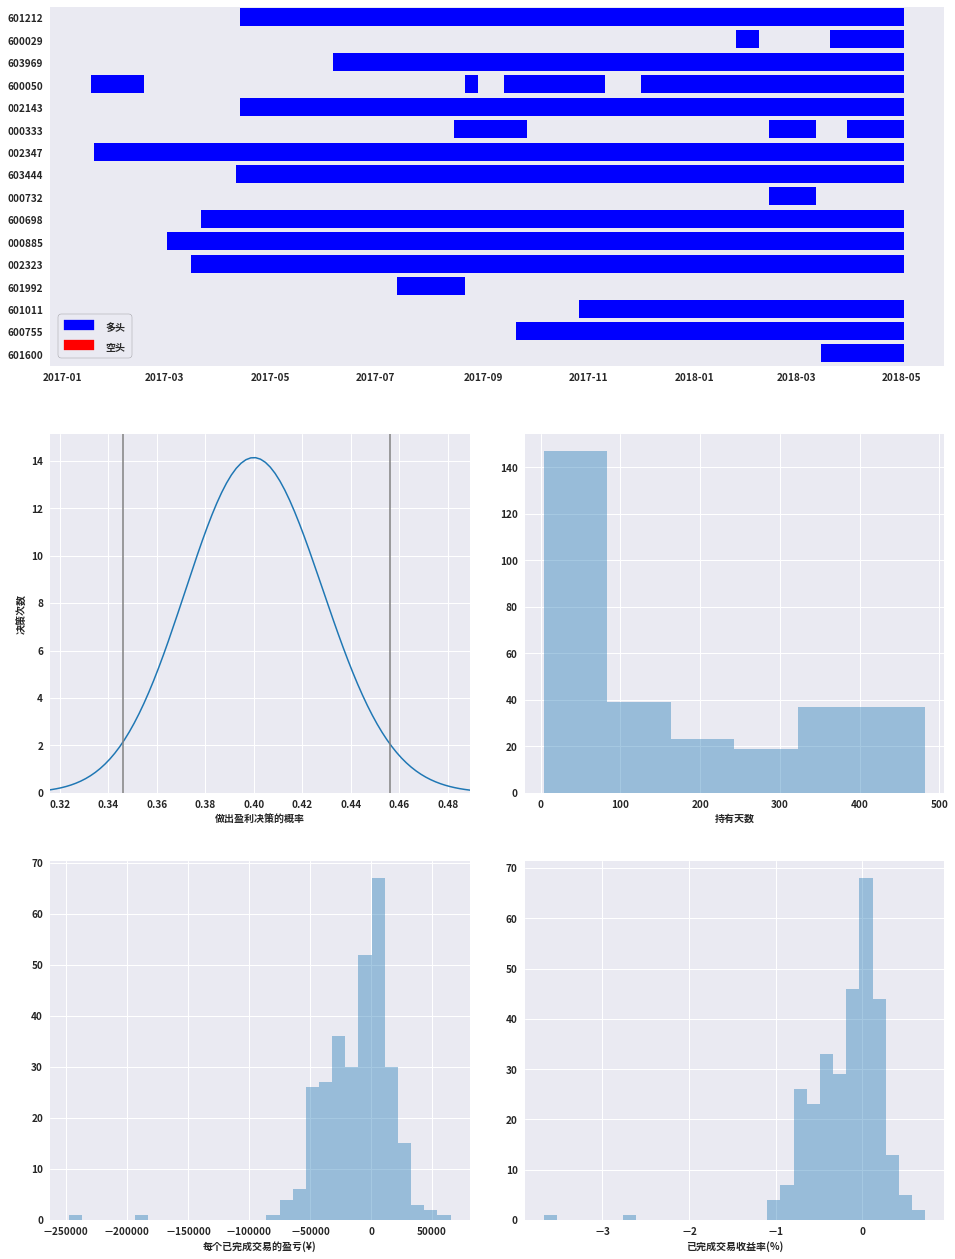

In [10]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          live_start_date=live_start_date, round_trips=True)

In [11]:
returns.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-16',
               ...
               '2018-04-17', '2018-04-18', '2018-04-19', '2018-04-20',
               '2018-04-23', '2018-04-24', '2018-04-25', '2018-04-26',
               '2018-04-27', '2018-05-02'],
              dtype='datetime64[ns, UTC]', length=322, freq=None)

### 整理及补充数据

#### 使用研究模块提取数据
+ 如果存在分红派息，自动调整期间股价
+ 必须与回测期间相同

from zipline.research import run_pipeline

from zipline.pipeline.fundamentals import Fundamentals
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.builtin import TopAverageAmount

def make_pipeline():

    return Pipeline(
        columns={
            'close': USEquityPricing.close.latest,
            'sector': Fundamentals.info.sector_code.latest,
        },
        # 只选择成交额前500位的股票
        screen=TopAverageAmount(500))

pipe_output = run_pipeline(make_pipeline(), '2018-1-1', '2018-5-2')

#### 整理数据

# 价格数据必须转换为日期为Index,stock为列名称的宽表
prices = pipe_output.unstack()['close']

prices.head()

factors = pipe_output['sector']
# 行业分类因子期间内不会改变，类型为整数
factors.fillna(method='bfill',inplace=True)
factors.fillna(method='ffill',inplace=True)
factors = factors.astype('int64')

factors.head()

### 因子分析

In [12]:
from alphalens.utils import get_clean_factor_and_forward_returns

/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [13]:
get_clean_factor_and_forward_returns(factor=factors, prices=prices,max_loss=0)

NameError: name 'factors' is not defined